# Import Libraries

In [ ]:
!pip install keras-core --upgrade
!pip install -q keras-nlp
!pip install seaborn
!pip install textstat
!pip install nltk
!pip install tensorflow
!pip install tensorflow_hub

In [ ]:
import pandas as pd
import numpy as np
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from textstat import flesch_reading_ease
import textstat

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import tensorflow as tf
import tensorflow_hub as hub
import keras_core as keras
import keras_nlp
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('wordnet')
nltk.download('punkt')

In [8]:
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("KerasNLP version:", keras_nlp.__version__)

TensorFlow version: 2.16.1
Keras version: 0.1.7
KerasNLP version: 0.9.3


# Loading the dataset

In [11]:
df=pd.read_csv(r'train_v2_drcat_02.csv')

In [12]:
df

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False
...,...,...,...,...,...
44863,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44864,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44865,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44866,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True


In [13]:
df['label'].value_counts()

label
0    27371
1    17497
Name: count, dtype: int64

# Data Sampling

In [14]:
# Creating a new column indicating human or AI
df['source'] = np.where(df['label'] == 0, 'human', 'AI')

# Select a random sample of 113 human-generated texts
human_texts = df[df['source'] == 'human'].sample(n=113, random_state=42)

# Select a random sample of 113 AI-generated texts
AI_texts = df[df['source'] == 'AI'].sample(n=113, random_state=42)

# Concatenate the selected human-generated texts with all AI-generated texts
matched_df = pd.concat([human_texts, AI_texts])

# Shuffle the DataFrame to mix human and AI texts
matched_df = matched_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Now matched_df contains an equal number of human and AI generated texts


In [15]:
matched_df

,text,label,prompt_name,source,RDizzl3_seven
0,"When school ends, and summer break begins, som...",0,Summer projects,human,False
1,United States.\n\nThe American Revolution was ...,1,"""A Cowboy Who Rode the Waves""",AI,True
2,"Hey, it's me, your average 8th grade student! ...",1,Seeking multiple opinions,AI,False
3,Online schooling provides many benefits which ...,1,Distance learning,AI,False
4,Having a balanced lifestyle of work and leisur...,1,Mandatory extracurricular activities,AI,False
...,...,...,...,...,...
221,"Venus is considered as Earth's twin, so why no...",0,Exploring Venus,human,True
222,"In the world of education, there have been man...",0,Distance learning,human,False
223,"Dear, principal\n\nI feel that you're new poli...",0,Grades for extracurricular activities,human,False
224,"Hey there! So, the telephone. Like, who would...",1,Driverless cars,AI,True


# Text Preprocessing

In [20]:
#Lemmatization
wc=WordNetLemmatizer()
corpus=[]
new_sw=[]
#preprocessing all the data
for i in range(0,226):
    review=matched_df['text'][i]
    review=re.sub('[^a-zA-Z]'," ",review)
    review=review.lower()
    #tokenization
    review=review.split()
    #removing stop words and applying stemming
    d=[]
    for word in review:
        if(word not in new_sw):
            d.append(wc.lemmatize(word))
    review=" ".join(d)
    #all the preprocessed review is saved in corpus
    corpus.append(review)

In [21]:
corpus

['when school end and summer break begin some school require student to complete summer project these project are to make sure student continue their education outside of school when teacher design the project student are more challenged with the work they are given however a student designed project is a much better choice student are more likely to do the work designed by them student will have le of a hard time and student will feel le stressed rather than having to do a more challenging project a project designed by a teacher can be dreadful enough let alone the fact that the project is over break student designed project are more likely to be completed due to the simple fact that the work would be more enjoyable for student when a student get work that they are able to enjoy they will complete it most teacher do not give out work that a student could enjoy they just give out boring work some student enjoy the work when there are more interactive activity within the project and som

# Feature Engineering

In [24]:
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
# from textstat import flesch_reading_ease
# import textstat

# Feature Engineering: Text Length
matched_df['text_length'] = matched_df['text'].apply(lambda x: len(x))

# Feature Engineering: Lexical Diversity
def calculate_lexical_diversity(text):
    tokens = word_tokenize(text.lower())
    unique_tokens = set(tokens)
    return len(unique_tokens) / len(tokens) if len(tokens) > 0 else 0

matched_df['lexical_diversity'] = matched_df['text'].apply(calculate_lexical_diversity)

# Feature Engineering: Readability Metrics
matched_df['flesch_reading_ease'] = matched_df['text'].apply(lambda x: flesch_reading_ease(x))


In [25]:
matched_df['text_length']

0      2750
1      2501
2      2096
3       848
4      1461
       ... 
221    2028
222    3279
223     930
224    1834
225    2560
Name: text_length, Length: 226, dtype: int64

In [26]:
matched_df['lexical_diversity']

0      0.289474
1      0.415730
2      0.425532
3      0.614286
4      0.486792
         ...   
221    0.417266
222    0.409567
223    0.569307
224    0.429280
225    0.496907
Name: lexical_diversity, Length: 226, dtype: float64

In [27]:
matched_df['flesch_reading_ease']

0      76.96
1      50.77
2      67.79
3      33.04
4      47.42
       ...  
221    75.74
222    73.10
223    88.26
224    86.30
225    65.93
Name: flesch_reading_ease, Length: 226, dtype: float64

In [28]:
# Create new DataFrame with selected columns
new_df = matched_df[['text', 'label', 'source', 'text_length', 'lexical_diversity', 'flesch_reading_ease']]

In [29]:
new_df

,text,label,source,text_length,lexical_diversity,flesch_reading_ease
0,"When school ends, and summer break begins, som...",0,human,2750,0.289474,76.96
1,United States.\n\nThe American Revolution was ...,1,AI,2501,0.415730,50.77
2,"Hey, it's me, your average 8th grade student! ...",1,AI,2096,0.425532,67.79
3,Online schooling provides many benefits which ...,1,AI,848,0.614286,33.04
4,Having a balanced lifestyle of work and leisur...,1,AI,1461,0.486792,47.42
...,...,...,...,...,...,...
221,"Venus is considered as Earth's twin, so why no...",0,human,2028,0.417266,75.74
222,"In the world of education, there have been man...",0,human,3279,0.409567,73.10
223,"Dear, principal\n\nI feel that you're new poli...",0,human,930,0.569307,88.26
224,"Hey there! So, the telephone. Like, who would...",1,AI,1834,0.429280,86.30


# Understanding source & text_length

In [30]:
# Filter AI-generated text with lengths less than 500, 1000 and greater than 1000
ai_less_than_1000 = new_df[(new_df['source'] == 'AI') & (new_df['text_length'] < 1000)].shape[0]
ai_less_than_500 = new_df[(new_df['source'] == 'AI') & (new_df['text_length'] < 500)].shape[0]
ai_greater_than_1000 = new_df[(new_df['source'] == 'AI') & (new_df['text_length'] > 1000)].shape[0]

# Filter human text with lengths less than 500, 1000 and greater than 1000
human_less_than_1000 = new_df[(new_df['source'] == 'human') & (new_df['text_length'] < 1000)].shape[0]
human_less_than_500 = new_df[(new_df['source'] == 'human') & (new_df['text_length'] < 500)].shape[0]
human_greater_than_1000 = new_df[(new_df['source'] == 'human') & (new_df['text_length'] > 1000)].shape[0]

print("AI-generated text with length < 500:", ai_less_than_500)
print("AI-generated text with length < 1000:", ai_less_than_1000)
print("AI-generated text with length > 1000:", ai_greater_than_1000)

print("Human text with length < 500:", human_less_than_500)
print("Human text with length < 1000:", human_less_than_1000)
print("Human text with length > 1000:", human_greater_than_1000)


AI-generated text with length < 500: 0
AI-generated text with length < 1000: 8
AI-generated text with length > 1000: 105
Human text with length < 500: 0
Human text with length < 1000: 5
Human text with length > 1000: 108


<ipython-input-31-5820b1183170>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate x-axis labels by 45 degrees


Text(0.5, 1.0, 'Distribution of prompt name')

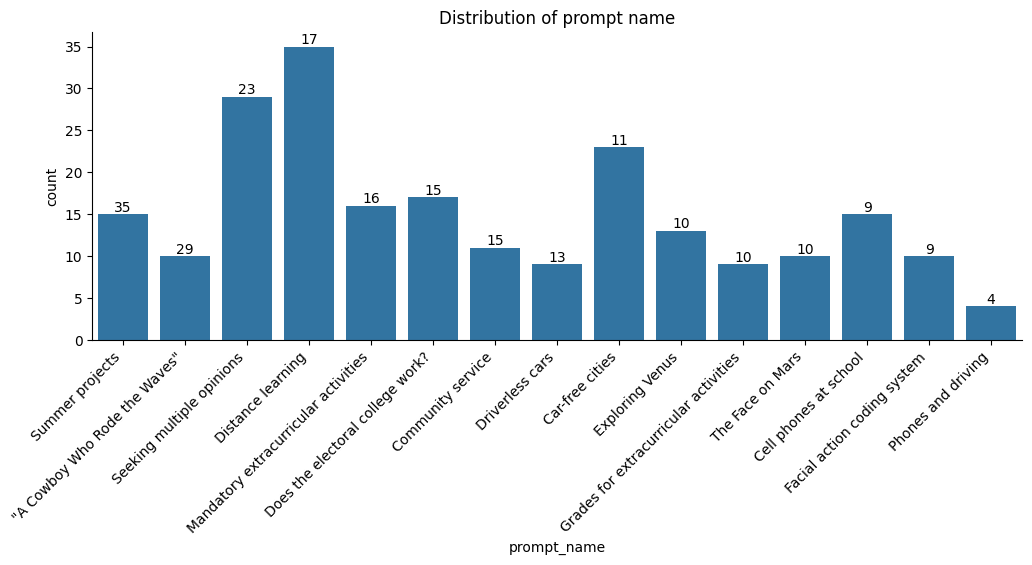

In [31]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=matched_df,
                   x="prompt_name")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate x-axis labels by 45 degrees

abs_values = matched_df['prompt_name'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of prompt name")


Text(0.5, 1.0, 'Distribution of Generated Text')

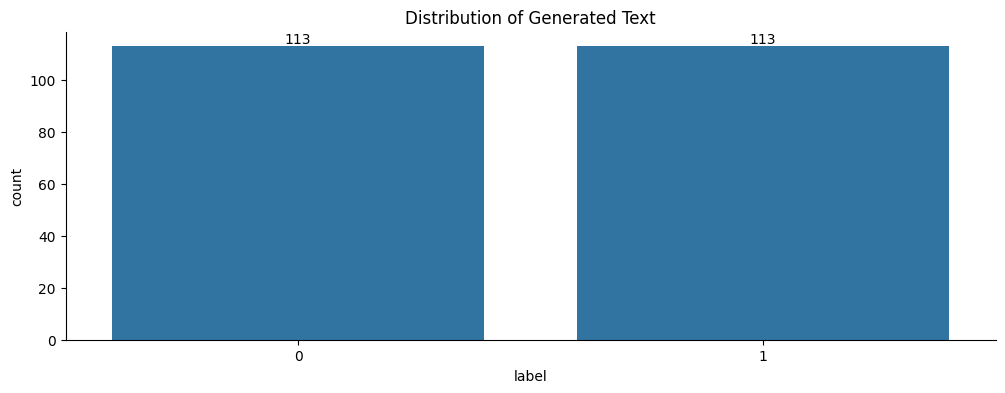

In [32]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=matched_df,
                   x="label")

abs_values = matched_df['label'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

# Understanding source & lexical_diversity

In [33]:
# Filter human and AI data separately
human_df = new_df[new_df['source'] == 'human']
ai_df = new_df[new_df['source'] == 'AI']

# Calculate min, max, and mode (most frequent) lexical diversity for human
human_min_lexical_diversity = human_df['lexical_diversity'].min()
human_max_lexical_diversity = human_df['lexical_diversity'].max()
human_mode_lexical_diversity = human_df['lexical_diversity'].mode()[0]  # Get the first mode if multiple modes exist

# Calculate min, max, and mode (most frequent) lexical diversity for AI
ai_min_lexical_diversity = ai_df['lexical_diversity'].min()
ai_max_lexical_diversity = ai_df['lexical_diversity'].max()
ai_mode_lexical_diversity = ai_df['lexical_diversity'].mode()[0]  # Get the first mode if multiple modes exist

# Print the results
print("Human Lexical Diversity:")
print("Minimum:", human_min_lexical_diversity)
print("Maximum:", human_max_lexical_diversity)
print("Mode:", human_mode_lexical_diversity)

print("\nAI Lexical Diversity:")
print("Minimum:", ai_min_lexical_diversity)
print("Maximum:", ai_max_lexical_diversity)
print("Mode:", ai_mode_lexical_diversity)


Human Lexical Diversity:
Minimum: 0.2040520984081042
Maximum: 0.58
Mode: 0.2040520984081042

AI Lexical Diversity:
Minimum: 0.2510548523206751
Maximum: 0.6880733944954128
Mode: 0.2510548523206751


# Understanding source & flesch_reading_ease

In [34]:
# Defining the readability ranges
readability_ranges = {
    'Very Difficult': (0, 30),
    'Difficult': (30, 50),
    'Moderate': (50, 70),
    'Easy': (70, 90),
    'Very Easy': (90, 100)
}

# Filter AI and human data separately
ai_df = new_df[new_df['source'] == 'AI']
human_df = new_df[new_df['source'] == 'human']

# Function to classify readability based on Flesch Reading Ease score
def classify_readability(score):
    for category, (lower, upper) in readability_ranges.items():
        if lower <= score < upper:
            return category

# Apply readability classification to AI essays
ai_df['Readability'] = ai_df['flesch_reading_ease'].apply(classify_readability)

# Apply readability classification to human essays
human_df['Readability'] = human_df['flesch_reading_ease'].apply(classify_readability)

# Print counts of essays in each readability category for AI and human sources
print("AI Essays Readability:")
print(ai_df['Readability'].value_counts())

print("\nHuman Essays Readability:")
print(human_df['Readability'].value_counts())


AI Essays Readability:
Readability
Moderate          53
Difficult         42
Easy              12
Very Difficult     4
Very Easy          1
Name: count, dtype: int64

Human Essays Readability:
Readability
Moderate     53
Easy         51
Difficult     5
Very Easy     4
Name: count, dtype: int64


<ipython-input-34-bfbb144e410a>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ai_df['Readability'] = ai_df['flesch_reading_ease'].apply(classify_readability)
<ipython-input-34-bfbb144e410a>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_df['Readability'] = human_df['flesch_reading_ease'].apply(classify_readability)


# Models

### Naive Bayes

In [35]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.model_selection import train_test_split
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.metrics import accuracy_score


# Feature Extraction (using TF-IDF)
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust the max_features parameter
X = tfidf_vectorizer.fit_transform(corpus)

# Splitting Data

y = matched_df['source']
print("X shape:", X.shape)
print("y shape:", y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Model Evaluation
y_pred_nb = nb_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_nb)
print("Accuracy:", accuracy)

X shape: (226, 1000)
y shape: (226,)
Accuracy: 0.8913043478260869


In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

          AI       1.00      0.77      0.87        22
       human       0.83      1.00      0.91        24

    accuracy                           0.89        46
   macro avg       0.91      0.89      0.89        46
weighted avg       0.91      0.89      0.89        46



### Logistic Regression

In [37]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(corpus, matched_df['source'], test_size=0.2, random_state=42)

# Vectorizing the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Training the Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train_tfidf, y_train)

# Predicting on the test set
y_pred_lr = logreg_model.predict(X_test_tfidf)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Accuracy:", accuracy)


Logistic Regression Accuracy: 0.8478260869565217


In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

          AI       0.89      0.77      0.83        22
       human       0.81      0.92      0.86        24

    accuracy                           0.85        46
   macro avg       0.85      0.84      0.85        46
weighted avg       0.85      0.85      0.85        46



### Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier

# Training the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# Predicting on the test set
y_pred_rf = rf_model.predict(X_test_tfidf)

# Calculating accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)



Random Forest Accuracy: 0.9347826086956522


In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

          AI       0.91      0.95      0.93        22
       human       0.96      0.92      0.94        24

    accuracy                           0.93        46
   macro avg       0.93      0.94      0.93        46
weighted avg       0.94      0.93      0.93        46



### BERT

In [45]:
# We choose 512 because it's the limit of DistilBert
SEQ_LENGTH = 512

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
    "distil_bert_base_en_uncased",
    sequence_length=SEQ_LENGTH,
)

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    "distil_bert_base_en_uncased",
    num_classes=2,
    activation=None,
    preprocessor=preprocessor,
)

# Re-compile (e.g., with a new learning rate)
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="Adam",  # Use the string name of the optimizer
    metrics=[
        keras.metrics.SparseCategoricalAccuracy()
    ]
)


# Access backbone programmatically (e.g., to change `trainable`).
classifier.backbone.trainable = False


classifier.summary()

Preprocessor: "distil_bert_preprocessor_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_2 (GetItem)          │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item_2[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 592,130 (2.26 MB)

 Non-trainable params: 66,362,880 (253.15 MB)

In [47]:
# Split the dataset into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(matched_df["text"],
                                                    matched_df["label"],
                                                    test_size=0.33,
                                                    random_state=42)

In [50]:
# Fit
classifier.fit(x=X_train,
               y=y_train,
               validation_data=(X_test, y_test),
               epochs=1,
               batch_size=64
              )

3/3 ━━━━━━━━━━━━━━━━━━━━ 328s 114s/step - loss: 0.4671 - sparse_categorical_accuracy: 0.7305 - val_loss: 0.4770 - val_sparse_categorical_accuracy: 0.7414


In [51]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Generated","Generated"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))


In [52]:
y_pred_test = classifier.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 110s 34s/step


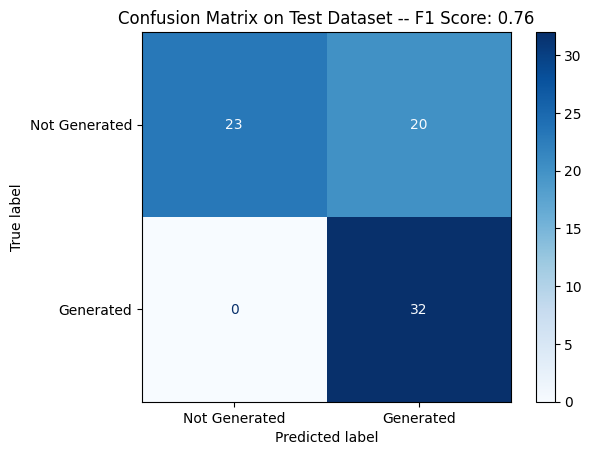

In [53]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
displayConfusionMatrix(y_test, y_pred_test,  "Test")